In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
% matplotlib inline
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.bbox"] = 'tight'
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter('ignore', (FutureWarning, ConvergenceWarning))

# Feature importances and Model interpretation

In [344]:
# generate data from original 2d linear model
from sklearn.preprocessing import scale

# 35 13 50? 
rng = np.random.RandomState(13)
n_samples = 100000
n_informative = 2
n_correlated_per_inf = 2
n_noise = 4
noise_std = .0001
noise_correlated_std = .51
noise_y = .3


X_original = rng.uniform(-1, 1, size=(n_samples, n_informative))
#coef = rng.normal(size=n_informative)
coef = np.array([-3.2, 1.4])
y = np.dot(X_original, coef) + rng.normal(scale=noise_y, size=n_samples)

correlated_transform = np.zeros((n_correlated_per_inf * n_informative, n_informative))
for i in range(n_informative):
    correlated_transform[i * n_correlated_per_inf: (i + 1) * n_correlated_per_inf, i] = rng.normal(size=n_correlated_per_inf)
X_original += rng.normal(scale=np.array([1, 1]) * noise_correlated_std, size=X_original.shape)
X_correlated = np.dot(X_original, correlated_transform.T)

X = np.hstack([X_correlated, np.zeros((n_samples, n_noise))])
X += rng.normal(scale=noise_std, size=X.shape)
X = scale(X)

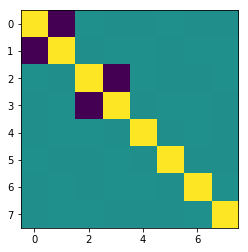

In [345]:
plt.imshow(np.cov(X, rowvar=False))

In [346]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [348]:
for i in range(X.shape[1]):
    lr = LinearRegression().fit(X_train[:, [i]], y_train)
    print(lr.score(X_test[:, [i]], y_test))

0.4532506867871262
0.4532514261726276
0.09275569004419326
0.09275599504713594
-0.00020773972150145426
-0.00017276124646903313
-0.00018329268681771538
-0.00020494411292082404


In [349]:
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression
lasso = LassoCV().fit(X_train, y_train)
lasso.score(X_test, y_test)

0.5453138625214944

In [350]:
ridge = RidgeCV().fit(X_train, y_train)
ridge.score(X_test, y_test)

0.5453306487434062

In [351]:
lr = LinearRegression().fit(X_train, y_train)
lr.score(X_test, y_test)

0.5453299378456281

In [352]:
from sklearn.decomposition import PCA
pca = PCA(n_components=.99).fit(X_train)
X_train_pca = pca.transform(X_train)
lr_pca = LinearRegression().fit(X_train_pca, y_train)
inverse_lr_pca_coef = pca.inverse_transform(lr_pca.coef_)
lr_pca.score(pca.transform(X_test), y_test)

0.5453305950074661

In [353]:
pca.n_components_

6

In [ ]:
def plot_importance(some_dict):
    plt.figure(figsize=(10, 4))
    df = pd.DataFrame(some_dict)
    ax = plt.gca()
    df.plot.bar(ax=ax, width=.9)
    ax.set_ylim(-1.5, 1.5)
    ax.set_xlim(-.5, len(df) - .5)
    ax.set_xlabel("feature index")
    ax.set_ylabel("importance value")
    plt.vlines(np.arange(.5, len(df) -1), -1.5, 1.5, linewidth=.5)

In [354]:
from sklearn.model_selection import cross_val_score

def drop_feature_importance(est, X, y):
    base_score = np.mean(cross_val_score(est, X, y, cv=5))
    scores = []
    for feature in range(X.shape[1]):
        mask = np.ones(X.shape[1], 'bool')
        mask[feature] = False
        X_new = X[:, mask]
        this_score = np.mean(cross_val_score(est, X_new, y, cv=5))
        scores.append(base_score - this_score)
    return np.array(scores)

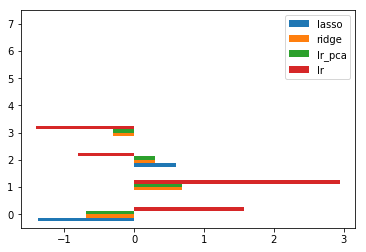

In [355]:
plot_importance({'lasso': lasso.coef_, 'ridge': ridge.coef_, 'lr_pca': inverse_lr_pca_coef, 'lr': lr.coef_})

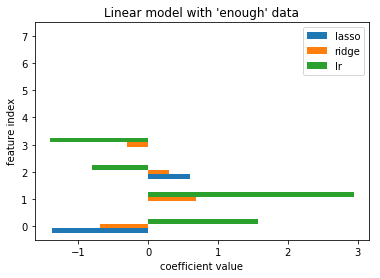

In [356]:
plot_importance({'lasso': lasso.coef_, 'ridge': ridge.coef_, 'lr': lr.coef_})
plt.ylabel("coefficient value")
plt.title("Linear model with 'enough' data")
plt.savefig("images/linear_enough_data.png")

In [384]:
drop_ridge = drop_feature_importance(ridge, X_train, y_train)
#drop_ridge /= np.linalg.norm(drop_ridge)

In [358]:
drop_ridge

array([-1.22570965e-07,  1.54983031e-07, -4.94336522e-08,  4.47408157e-08,
       -9.41619574e-06, -2.97787960e-06, -7.21816179e-07, -2.83562778e-06])

In [359]:
"""Permutation importance for estimators"""
# from https://github.com/scikit-learn/scikit-learn/pull/13146/
import numpy as np

from sklearn.utils import check_random_state
from sklearn.metrics import check_scoring


def permutation_importance(estimator, X, y, scoring=None, n_bootstrap=30,
                           random_state=None):
    """Permutation importance for feature evaluation.
    The permutation importance of a feature is calculated as follows. First,
    the estimator is trained on a training set. Then a baseline metric, defined
    by ``scoring``, is evaluated on a validation set. Next, a feature column
    from the validation set is permuted and the metric is evaluated again.
    The permutation importance is defined to be the difference between the
    baseline metric and metric from permutating the feature column.
    Parameters
    ----------
    estimator : object
        A estimator that has already been `fit` and is compatible with
        ``scorer``.
    X : array-like, shape = (n_samples, n_features)
        Training data.
    y : array-like, shape = (n_samples, ...)
        Target relative to ``X``.
    scoring : string, callable or None, optional (default=None)
        A string (see model evaluation documentation) or
        a scorer callable object / function with signature
        ``scorer(estimator, X, y)``.
    n_bootstrap : int, optional (default=30)
        Number of times to permute a feature
    random_state : int, RandomState instance or None, optional, default None
        The seed of the pseudo random number generator that selects a random
        feature to update.  If int, random_state is the seed used by the random
        number generator; If RandomState instance, random_state is the random
        number generator; If None, the random number generator is the
        RandomState instance used by `np.random`.
    Returns
    -------
    scores : array, shape (n_features, bootstrap_samples)
        Permutation importance scores
    """

    random_state = check_random_state(random_state)
    scoring = check_scoring(estimator, scoring=scoring)
    scores = np.empty(shape=(X.shape[1], n_bootstrap), dtype=np.float)

    baseline_score = scoring(estimator, X, y)
    for f_idx in range(X.shape[1]):
        for b_idx in range(n_bootstrap):
            original_feature = X[:, f_idx].copy()
            random_state.shuffle(X[:, f_idx])
            feature_score = scoring(estimator, X, y)
            scores[f_idx, b_idx] = baseline_score - feature_score
            X[:, f_idx] = original_feature

    return scores

In [425]:
perm_ridge_test = permutation_importance(ridge, X_test, y_test).mean(axis=1)

In [427]:
perm_ridge_test

array([ 2.25841711e-01,  2.26896482e-01,  4.58536333e-02,  4.60163986e-02,
       -1.16940500e-06, -5.11330670e-07,  1.76582158e-05,  1.43801483e-07])

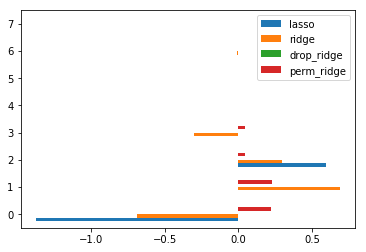

In [362]:
plot_importance({'lasso': lasso.coef_, 'ridge': ridge.coef_, 'drop_ridge': drop_ridge,
              'perm_ridge': perm_ridge_test.mean(axis=1)})

In [413]:
import shap

def shap_linear(model, X_train, X_test):
    linear_explainer = shap.LinearExplainer(model, X_train)
    shap_values = linear_explainer.shap_values(X_test)
    s = shap_values.mean(axis=0)
    s /= np.linalg.norm(s)
    return s

shap_ridge = shap_linear(ridge, X_train, X_test)

/home/andy/anaconda3/envs/py37/lib/python3.7/site-packages/shap/explainers/linear.py:47: UserWarning: The default value for feature_dependence has been changed to "independent"!
  warnings.warn('The default value for feature_dependence has been changed to "independent"!')


In [414]:
shap_lasso = shap_linear(lasso, X_train, X_test)

/home/andy/anaconda3/envs/py37/lib/python3.7/site-packages/shap/explainers/linear.py:47: UserWarning: The default value for feature_dependence has been changed to "independent"!
  warnings.warn('The default value for feature_dependence has been changed to "independent"!')


In [416]:
drop_lasso = drop_feature_importance(lasso, X_train, y_train)
drop_lasso

array([-2.76313574e-07,  2.28129837e-09, -8.66300642e-08,  1.38552603e-09,
       -3.91074013e-06, -1.26566080e-06, -2.06624854e-06, -1.37591301e-06])

In [428]:
perm_lasso_test = permutation_importance(lasso, X_test, y_test).mean(axis=1)

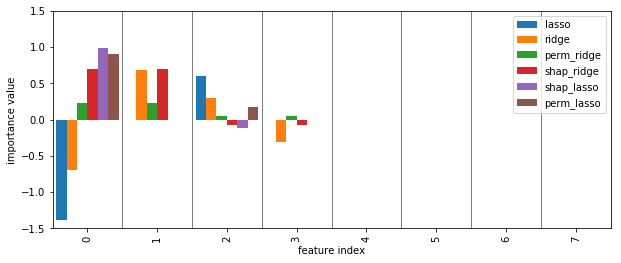

In [471]:



plot_importance({'lasso': lasso.coef_, 'ridge': ridge.coef_,
              'perm_ridge': perm_ridge_test, 'shap_ridge': shap_ridge, 'shap_lasso': shap_lasso, 'perm_lasso': perm_lasso_test})

In [440]:
# X_test is actually big, not small, but that would be confusing naming, right?
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X, y, train_size=0.001, random_state=0)
X_train_small.shape

(100, 8)

In [441]:
lasso_small = LassoCV().fit(X_train_small, y_train_small)
lasso_small.score(X_test_small, y_test_small)

0.5361580595868876

In [442]:
ridge_small = RidgeCV().fit(X_train_small, y_train_small)
ridge_small.score(X_test_small, y_test_small)

0.5336853626423791

In [443]:
lr_small = LinearRegression().fit(X_train_small, y_train_small)
lr_small.score(X_test_small, y_test_small)

0.5262746934049003

In [444]:
from sklearn.decomposition import PCA
pca_small = PCA(n_components=.99).fit(X_train_small)
X_train_pca = pca_small.transform(X_train_small)
lr_pca_small = LinearRegression().fit(X_train_pca, y_train_small)
inverse_lr_pca_coef = pca.inverse_transform(lr_pca_small.coef_)
lr_pca_small.score(pca_small.transform(X_test_small), y_test_small)

0.5303117477435796

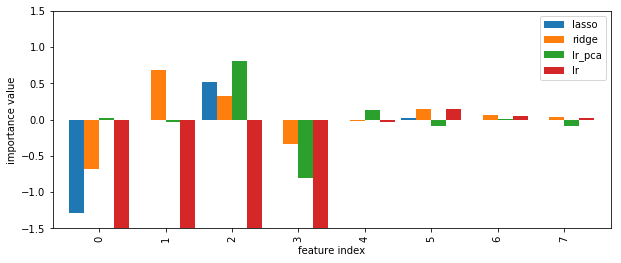

In [445]:
plot_importance({'lasso': lasso_small.coef_, 'ridge': ridge_small.coef_, 'lr_pca': inverse_lr_pca_coef, 'lr': lr_small.coef_})

In [447]:
perm_ridge_test_small = permutation_importance(ridge, X_test_small, y_test_small).mean(axis=1)
perm_lasso_test_small = permutation_importance(lasso, X_test_small, y_test_small).mean(axis=1)
shap_ridge_small = shap_linear(ridge_small, X_train_small, X_test_small)
shap_lasso_small = shap_linear(lasso_small, X_train_small, X_test_small)

/home/andy/anaconda3/envs/py37/lib/python3.7/site-packages/shap/explainers/linear.py:47: UserWarning: The default value for feature_dependence has been changed to "independent"!
  warnings.warn('The default value for feature_dependence has been changed to "independent"!')


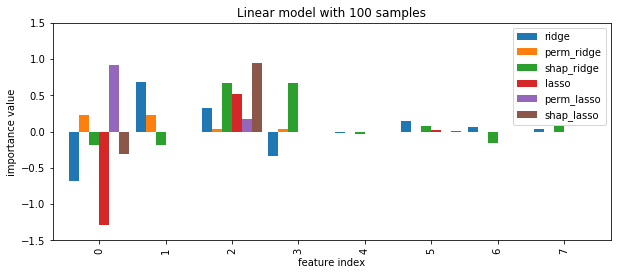

In [449]:
plot_importance({'ridge': ridge_small.coef_,
                 'perm_ridge': perm_ridge_test_small, 'shap_ridge': shap_ridge_small,
                 'lasso': lasso_small.coef_, 'perm_lasso': perm_lasso_test_small, 'shap_lasso': shap_lasso_small})
plt.title("Linear model with 100 samples")
plt.savefig("images/linear_less_data.png")

In [450]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {'max_leaf_nodes': range(5, 40, 5)}
grid = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=10, n_jobs=3)
grid.fit(X_train, y_train)
grid.score(X_test, y_test)

0.5452326112689287

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_leaf_nodes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.309888,0.053832,0.001004,0.000108,5,{'max_leaf_nodes': 5},0.462604,0.440588,0.473126,0.457954,0.452981,0.473005,0.451614,0.461949,0.472736,0.461263,0.460782,0.010051,7
1,0.395562,0.061563,0.001015,0.000129,10,{'max_leaf_nodes': 10},0.521506,0.493712,0.528441,0.518701,0.511587,0.527171,0.511400,0.515145,0.529097,0.514606,0.517136,0.010079,6
2,0.440545,0.075654,0.001059,0.000156,15,{'max_leaf_nodes': 15},0.538750,0.508512,0.540610,0.531709,0.524862,0.537812,0.525124,0.529646,0.540629,0.526967,0.530462,0.009408,5
3,0.468492,0.081900,0.001071,0.000143,20,{'max_leaf_nodes': 20},0.545687,0.518108,0.548601,0.538756,0.530536,0.545101,0.532595,0.534600,0.550455,0.534542,0.537898,0.009389,4
4,0.479202,0.082315,0.001099,0.000135,25,{'max_leaf_nodes': 25},0.550942,0.523627,0.554485,0.544066,0.535281,0.548459,0.536858,0.541139,0.556123,0.541021,0.543200,0.009369,3
5,0.501127,0.087966,0.001069,0.000124,30,{'max_leaf_nodes': 30},0.556703,0.526756,0.557474,0.548513,0.539379,0.552334,0.541503,0.545559,0.559992,0.544634,0.547285,0.009531,2
6,0.507691,0.075645,0.001081,0.000135,35,{'max_leaf_nodes': 35},0.558192,0.529447,0.559883,0.550660,0.540523,0.554659,0.543968,0.547745,0.562581,0.545966,0.549362,0.009545,1


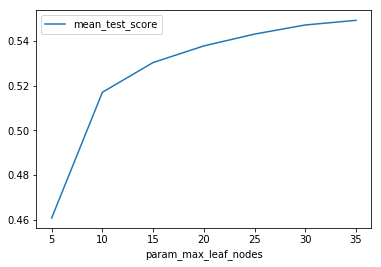

In [451]:
res = pd.DataFrame(grid.cv_results_)
res.plot(x='param_max_leaf_nodes', y='mean_test_score')
res

In [452]:
grid.best_estimator_.feature_importances_

array([0.7532024 , 0.09101644, 0.08202745, 0.07375371, 0.        ,
       0.        , 0.        , 0.        ])

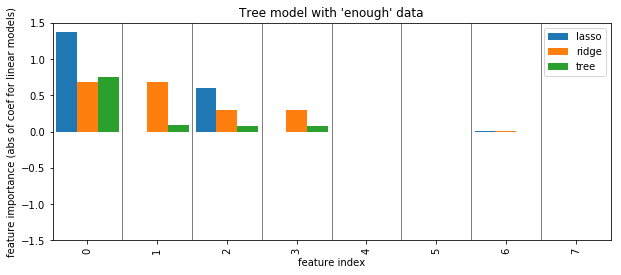

In [485]:
plot_importance({'lasso': np.abs(lasso.coef_), 'ridge': np.abs(ridge.coef_), 'tree': grid.best_estimator_.feature_importances_})
plt.ylabel("feature importance (abs of coef for linear models)")
plt.title("Tree model with 'enough' data")
plt.savefig("images/tree_enough_data.png")

In [454]:
param_grid = {'max_leaf_nodes': range(2, 20)}
grid_tree_small = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=10, n_jobs=3)
grid_tree_small.fit(X_train_small, y_train_small)
grid_tree_small.score(X_test_small, y_test_small)

0.34448907322890654

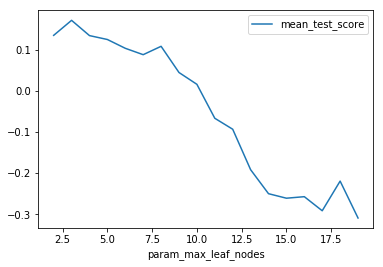

In [455]:
res = pd.DataFrame(grid_tree_small.cv_results_)
res.plot(x='param_max_leaf_nodes', y='mean_test_score')

In [456]:
grid_tree_small.best_estimator_.max_leaf_nodes

3

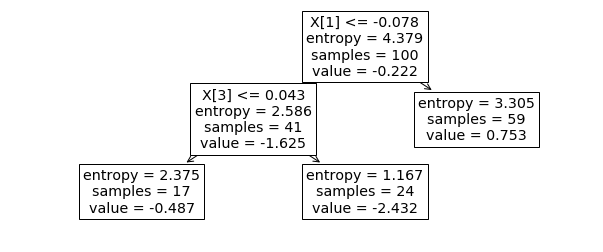

In [457]:
from sklearn.tree import plot_tree
plt.figure(figsize=(10, 4))
plot_tree(grid_tree_small.best_estimator_);

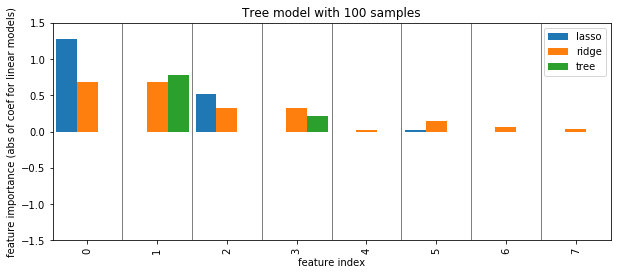

In [472]:
plot_importance({'lasso': np.abs(lasso_small.coef_), 'ridge': np.abs(ridge_small.coef_), 'tree': grid_tree_small.best_estimator_.feature_importances_})
plt.ylabel("feature importance (abs of coef for linear models)")
plt.title("Tree model with 100 samples")
plt.savefig("images/tree_less_data.png")

In [459]:
dt = DecisionTreeRegressor(max_leaf_nodes=3).fit(X_train_small[:, [0, 2]], y_train_small)
dt.score(X_test_small[:, [0, 2]], y_test_small)

0.34452144133533447

In [475]:
best_tree = grid_tree_small.best_estimator_
drop_tree_small = drop_feature_importance(best_tree, X_train_small, y_train_small)
perm_tree_small = permutation_importance(best_tree, X_test_small, y_test_small).mean(axis=1)

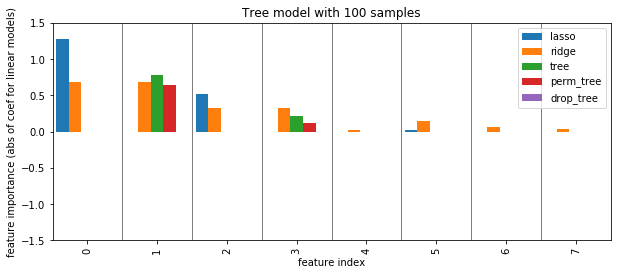

In [476]:
plot_importance({'lasso': np.abs(lasso_small.coef_), 'ridge': np.abs(ridge_small.coef_), 'tree': grid_tree_small.best_estimator_.feature_importances_,
                 'perm_tree': perm_tree_small, 'drop_tree': drop_tree_small})
plt.ylabel("feature importance (abs of coef for linear models)")
plt.title("Tree model with 100 samples")
plt.savefig("images/tree_less_data_all.png")

In [480]:
def shap_trees(model, X_train, X_test):
    tree_explainer = shap.TreeExplainer(model, X_train)
    shap_values = tree_explainer.shap_values(X_test)
    s = shap_values.mean(axis=0)
    s /= np.linalg.norm(s)
    return s

In [481]:
shap_tree_small = shap_trees(best_tree, X_train_small, X_test_small)

# Random Forest

In [482]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100).fit(X_train, y_train)
rf.score(X_test, y_test)

NameError: name 'r' is not defined

0.5359354408860038

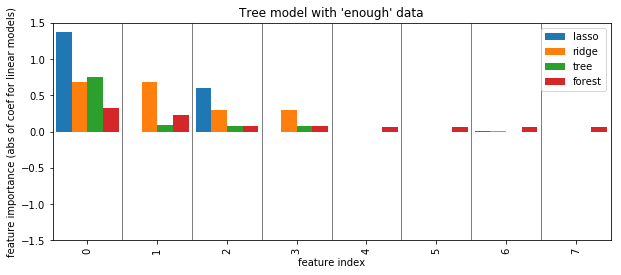

In [486]:
plot_importance({'lasso': np.abs(lasso.coef_), 'ridge': np.abs(ridge.coef_), 'tree': grid.best_estimator_.feature_importances_, 'forest': rf.feature_importances_})
plt.ylabel("feature importance (abs of coef for linear models)")
plt.title("Tree model with 'enough' data")
plt.savefig("images/forest_enough_data.png")

In [491]:
rf_small = RandomForestRegressor(n_estimators=100).fit(X_train_small, y_train_small)
rf_small.score(X_test_small, y_test_small)

0.44742420319303305

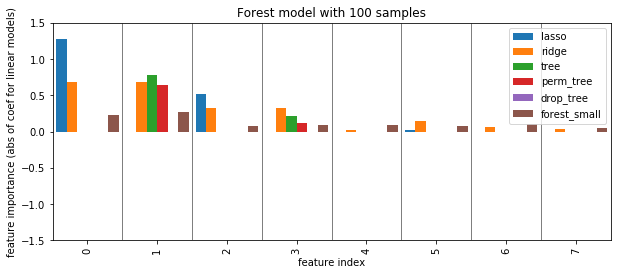

In [492]:
plot_importance({'lasso': np.abs(lasso_small.coef_), 'ridge': np.abs(ridge_small.coef_), 'tree': grid_tree_small.best_estimator_.feature_importances_,
                 'perm_tree': perm_tree_small, 'drop_tree': drop_tree_small, 'forest_small': rf_small.feature_importances_})
plt.ylabel("feature importance (abs of coef for linear models)")
plt.title("Forest model with 100 samples")
plt.savefig("images/forest_less_data_all.png")

In [493]:
perm_forest_small = permutation_importance(rf, X_test_small, y_test_small).mean(axis=1)

In [ ]:
shap_forest_small = shap_trees(rf, X_train_small, X_test_small)

In [ ]:
plot_importance({'lasso': np.abs(lasso_small.coef_), 'ridge': np.abs(ridge_small.coef_), 'tree': grid_tree_small.best_estimator_.feature_importances_,
                 'perm_tree': perm_tree_small, 'drop_tree': drop_tree_small, 'forest_small': rf_small.feature_importances_,
                 'perm_forest': perm_forest_small, 'shap_forest': shap_forest_small})
plt.ylabel("feature importance (abs of coef for linear models)")
plt.title("Forest model with 100 samples")
plt.savefig("images/forest_less_data_all.png")

# Partial Dependence

In [7]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(
    boston.data, boston.target, random_state=0)

gbrt = GradientBoostingRegressor().fit(X_train, y_train)
gbrt.score(X_test, y_test)

0.8149062563140078

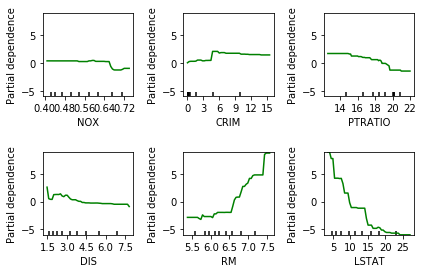

In [8]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
fig, axs = plot_partial_dependence(gbrt, X_train, np.argsort(gbrt.feature_importances_)[-6:],
                                       feature_names=boston.feature_names,
                                       n_jobs=3, grid_resolution=50)
plt.tight_layout()

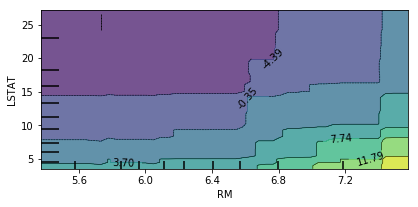

In [9]:
fig, axs = plot_partial_dependence(gbrt, X_train, [np.argsort(gbrt.feature_importances_)[-2:]],
                                   feature_names=boston.feature_names,

                                   n_jobs=3, grid_resolution=50)

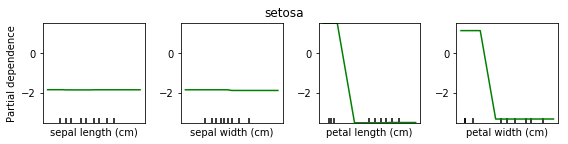

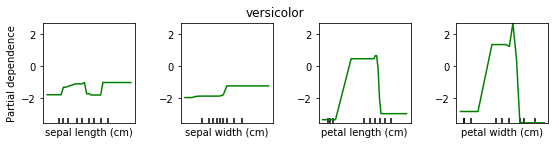

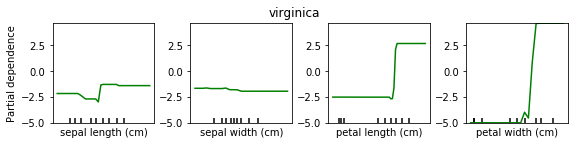

In [13]:
from sklearn.datasets import load_iris
from sklearn.ensemble import GradientBoostingClassifier


iris = load_iris()

X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, stratify=iris.target, random_state=0)
gbrt = GradientBoostingClassifier().fit(X_train, y_train)
gbrt.score(X_test, y_test)

from sklearn.ensemble.partial_dependence import plot_partial_dependence
for i in range(3):
    fig, axs = plot_partial_dependence(gbrt, X_train, range(4), n_cols=4,
                                       feature_names=iris.feature_names, grid_resolution=50, label=i,
                                       figsize=(8, 2))
    fig.suptitle(iris.target_names[i])
    for ax in axs: ax.set_xticks(())
    for ax in axs[1:]: ax.set_ylabel("")

    plt.tight_layout()


# Feature Selection

In [7]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

In [8]:
boston = load_boston()
X, y = boston.data, boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [9]:
from sklearn.preprocessing import scale
X_train_scaled = scale(X_train)
cov = np.cov(X_train_scaled, rowvar=False)

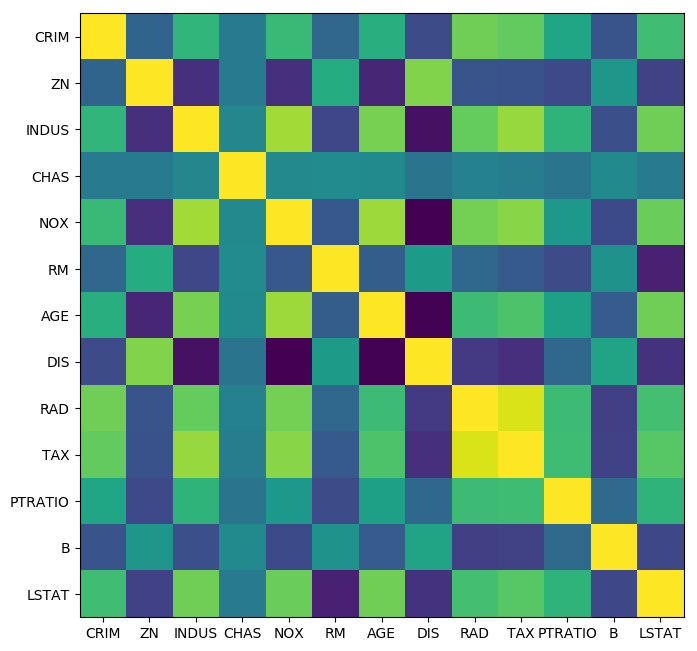

In [10]:
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(cov)
plt.xticks(range(X.shape[1]), boston.feature_names)
plt.yticks(range(X.shape[1]), boston.feature_names);

In [11]:
from scipy.cluster import hierarchy
order = np.array(hierarchy.dendrogram(hierarchy.ward(cov), no_plot=True)['ivl'], dtype="int")

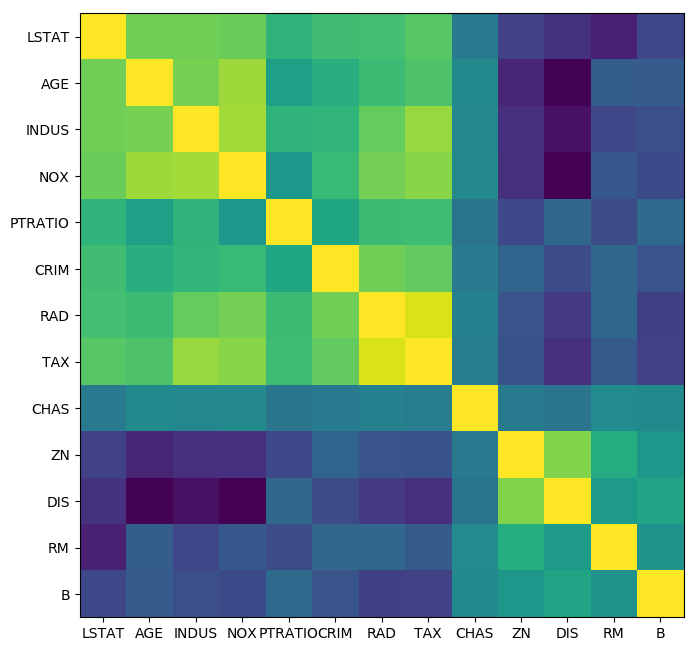

In [12]:
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(cov[order, :][:, order])
plt.xticks(range(X.shape[1]), boston.feature_names[order])
plt.yticks(range(X.shape[1]), boston.feature_names[order]);

# Supervised feature selection

In [13]:
from sklearn.feature_selection import f_regression
f_values, p_values = f_regression(X, y)

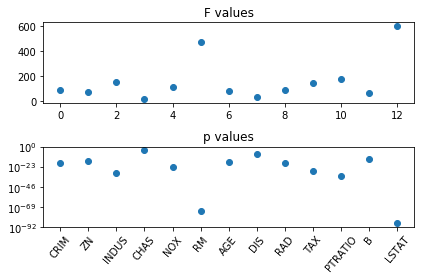

In [14]:
fig, ax = plt.subplots(2, 1)
ax[0].set_title("F values")
ax[0].plot(f_values, 'o')
ax[1].set_title("p values")
ax[1].plot(p_values, 'o')
ax[1].set_yscale("log")

ax[1].set_xticks(range(X.shape[1]))
ax[1].set_xticklabels(boston.feature_names, rotation=50);
fig.tight_layout()

In [15]:
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFpr
from sklearn.linear_model import RidgeCV

select = SelectKBest(k=2, score_func=f_regression)
select.fit(X_train, y_train)
print(X_train.shape)
print(select.transform(X_train).shape)

(379, 13)
(379, 2)


In [19]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
all_features = make_pipeline(StandardScaler(), RidgeCV())
select_2 = make_pipeline(StandardScaler(), SelectKBest(k=2, score_func=f_regression), RidgeCV())

In [21]:
from sklearn.model_selection import cross_val_score
np.mean(cross_val_score(all_features, X_train, y_train, cv=10))

0.71795885107509

In [22]:
np.mean(cross_val_score(select_2, X_train, y_train, cv=10))

0.6243625749168433

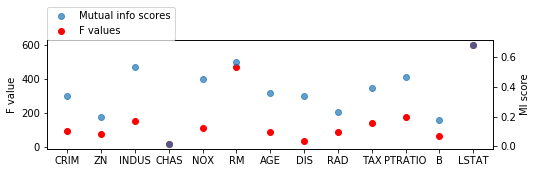

In [23]:
from sklearn.feature_selection import mutual_info_regression
scores = mutual_info_regression(X_train, y_train, discrete_features=[3])

fig = plt.figure(figsize=(8, 2))
line_f, = plt.plot(f_values, 'o', c='r')
plt.ylabel("F value")
ax2 = plt.twinx()
line_s, = ax2.plot(scores, 'o', alpha=.7)
ax2.set_ylabel("MI score")
plt.xticks(range(X.shape[1]), boston.feature_names)
plt.legend([line_s, line_f], ["Mutual info scores", "F values"], loc=(0, 1))

In [35]:
from sklearn.linear_model import Lasso
X_train_scaled = scale(X_train)
lasso = LassoCV().fit(X_train_scaled, y_train)
print(lasso.coef_)

[-0.          0.         -0.          0.         -0.          2.52933025
 -0.         -0.         -0.         -0.22763148 -1.70088382  0.13186059
 -3.60565498]


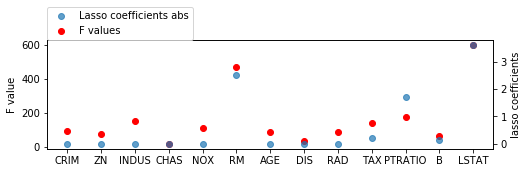

In [36]:
fig = plt.figure(figsize=(8, 2))
line_f, = plt.plot(f_values, 'o', c='r')
plt.ylabel("F value")
ax2 = plt.twinx()
ax2.set_ylabel("lasso coefficients")
line_s, = ax2.plot(np.abs(lasso.coef_), 'o', alpha=.7)
plt.xticks(range(X.shape[1]), boston.feature_names)
plt.legend([line_s, line_f], ["Lasso coefficients abs", "F values"], loc=(0, 1))

In [37]:
from sklearn.linear_model import Lasso
X_train_scaled = scale(X_train)
lasso = Lasso().fit(X_train_scaled, y_train)
print(lasso.coef_)

[-0.          0.         -0.          0.         -0.          2.52933025
 -0.         -0.         -0.         -0.22763148 -1.70088382  0.13186059
 -3.60565498]


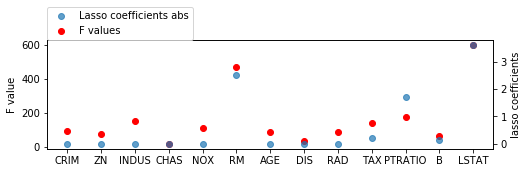

In [38]:
fig = plt.figure(figsize=(8, 2))
line_f, = plt.plot(f_values, 'o', c='r')
plt.ylabel("F value")
ax2 = plt.twinx()
ax2.set_ylabel("lasso coefficients")
line_s, = ax2.plot(np.abs(lasso.coef_), 'o', alpha=.7)
plt.xticks(range(X.shape[1]), boston.feature_names)
plt.legend([line_s, line_f], ["Lasso coefficients abs", "F values"], loc=(0, 1))

In [40]:
X_train.shape

(379, 13)

In [44]:
from sklearn.feature_selection import SelectFromModel
select_lassocv = SelectFromModel(LassoCV())
select_lassocv.fit(X_train, y_train)
print(select_lassocv.transform(X_train).shape)

(379, 11)


In [45]:
pipe_lassocv = make_pipeline(StandardScaler(), select_lassocv, RidgeCV())
np.mean(cross_val_score(pipe_lassocv, X_train, y_train, cv=10))

0.7171231551882247

In [79]:
np.mean(cross_val_score(all_features, X_train, y_train, cv=10))

0.71798347520832284

In [68]:
# could grid-search alpha in lasso
select_lasso = SelectFromModel(Lasso())
pipe_lasso = make_pipeline(StandardScaler(), select_lasso, RidgeCV())
np.mean(cross_val_score(pipe_lasso, X_train, y_train, cv=10))

0.67051240477576868

In [69]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

# create ranking among all features by selecting only one
rfe = RFE(LinearRegression(), n_features_to_select=1)
rfe.fit(X_train_scaled, y_train)
rfe.ranking_

array([ 9,  8, 13, 11,  5,  2, 12,  4,  7,  6,  3, 10,  1])

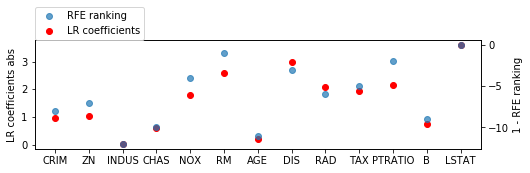

In [70]:
lr = LinearRegression().fit(X_train_scaled, y_train)
fig = plt.figure(figsize=(8, 2))
line_f, = plt.plot(np.abs(lr.coef_), 'o', c='r')
plt.ylabel("LR coefficients abs")
ax2 = plt.twinx()
ax2.set_ylabel("1 - RFE ranking")
line_s, = ax2.plot(1 - rfe.ranking_, 'o', alpha=.7)
plt.xticks(range(X.shape[1]), boston.feature_names)
plt.legend([line_s, line_f], ["RFE ranking", "LR coefficients"], loc=(0, 1))

In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV

rfe = RFECV(LinearRegression(), cv=10)
rfe.fit(X_train_scaled, y_train)
print(rfe.support_)
print(boston.feature_names[rfe.support_])

[ True  True False  True  True  True False  True  True  True  True  True
  True]
['CRIM' 'ZN' 'CHAS' 'NOX' 'RM' 'DIS' 'RAD' 'TAX' 'PTRATIO' 'B' 'LSTAT']


In [72]:
pipe_rfe_ridgecv = make_pipeline(StandardScaler(), RFECV(LinearRegression(), cv=10), RidgeCV())
np.mean(cross_val_score(pipe_rfe_ridgecv, X_train, y_train, cv=10))

0.71019583375843598

In [73]:
from sklearn.preprocessing import PolynomialFeatures
pipe_rfe_ridgecv = make_pipeline(StandardScaler(), PolynomialFeatures(), RFECV(LinearRegression(), cv=10), RidgeCV())
np.mean(cross_val_score(pipe_rfe_ridgecv, X_train, y_train, cv=10))

0.82031507795494429

In [74]:
pipe_rfe_ridgecv.fit(X_train, y_train)
print(pipe_rfe_ridgecv.named_steps['rfecv'].support_)

[False  True  True  True False  True  True  True False  True  True False
  True  True False  True  True  True  True False False False  True  True
  True False False  True  True False  True False False False False  True
  True  True False  True False False False  True  True  True  True  True
  True  True False  True False False  True False False False  True False
 False False  True  True  True  True  True False False False  True  True
 False  True  True False False False False  True  True False  True  True
  True  True False False  True  True  True  True  True  True  True  True
  True False  True False  True False False False  True]


In [75]:
from mlxtend.feature_selection import SequentialFeatureSelector
sfs = SequentialFeatureSelector(LinearRegression(), forward=False, k_features=7)
sfs.fit(X_train_scaled, y_train)

ModuleNotFoundError: No module named 'mlxtend'

In [ ]:
print(sfs.k_feature_idx_)
print(boston.feature_names[np.array(sfs.k_feature_idx_)])

In [ ]:
sfs.k_score_